In [1]:
import liftout

from liftout.fibsem import acquire, calibration
from autoscript_sdb_microscope_client.structures import AdornedImage

import pandas as pd

## Cross Correlation Tuning

In [ ]:

img1 = AdornedImage.load("crosscorrelation_1_ib.tif")
img2 = AdornedImage.load("crosscorrelation_2_ib.tif")

target_dx, target_dy = 2e-6, -5e-6


lp_values = [8, 16, 32, 64, 128, 256]
hp_values = [1.5, 3, 6, 12, 24, 48]
sigma_values = [2.5, 5, 10, 20, 45]


df = pd.DataFrame()
from tqdm.notebook import tqdm

n_exp = len(lp_values) * len(hp_values) * len(sigma_values)
pbar = tqdm(total=n_exp)

counter = 0
for i, lp in enumerate(lp_values):
    for j, hp in enumerate(hp_values):
        for k, sigma in enumerate(sigma_values):
            
            if hp > lp:
                continue
            frac=(counter / n_exp)
#             print(counter, frac)
#             print(counter)
#             pbar.update(counter)
            pbar.set_description(f"EXP {counter}/{n_exp}: ({lp}, {hp}, {sigma})")
                        
            dx, dy = calibration.shift_from_crosscorrelation_AdornedImages(
                img1, img2, lowpass=lp, highpass=hp, sigma=sigma, use_rect_mask=True)

#             print(f"{lp}, {hp}, {sigma}, {dx:.3e}, {dy:.3e} {abs(dx - target_dx):.3e}, {abs(dy - target_dy):.3e}")
            
            record = {"lp": lp, "hp": hp, "sigma": sigma, "dx": dx, "dy": dy, "target_dx": target_dx, "target_dy": target_dy}

            df = df.append(record, ignore_index=True)
            counter+=1

pbar.close()

In [83]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


df["d_dx"] = abs(df["dx"] - df["target_dx"])
df["d_dy"] = abs(df["dy"] - df["target_dy"])
df["delta"] = df["d_dx"] + df["d_dy"] * 1e7
print(df.sort_values(["delta", "d_dx", "d_dy"]).head(50))



        dx         dy       hp    lp    sigma  target_dx  target_dy    d_dx       d_dy     delta
81   1.693e-06 -4.329e-06  24.0   32.0   5.0   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
82   1.693e-06 -4.329e-06  24.0   32.0  10.0   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
84   1.693e-06 -4.329e-06  24.0   32.0  45.0   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
90   1.693e-06 -4.329e-06   1.5   64.0   2.5   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
91   1.693e-06 -4.329e-06   1.5   64.0   5.0   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
92   1.693e-06 -4.329e-06   1.5   64.0  10.0   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
93   1.693e-06 -4.329e-06   1.5   64.0  20.0   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
94   1.693e-06 -4.329e-06   1.5   64.0  45.0   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
95   1.693e-06 -4.329e-06   3.0   64.0   2.5   2.000e-06 -5.000e-06  3.073e-07  6.706e-07  6.706
96   1.693e-06 -4.329e-06   3.

In [12]:
import plotly.graph_objects as go
import datetime
import numpy as np

fig = go.Figure(data=go.Heatmap(
        z=df["delta"],
        x=df["lp"],
        y=df["hp"]))


fig.update_layout(
    title='Distance from target value')

fig.show()


fig = go.Figure(data=go.Heatmap(
        z=df["delta"],
        x=df["lp"],
        y=df["sigma"]))


fig.update_layout(
    title='Distance from target value')

fig.show()

3.25521e-08
-52.00893337142612 132.98681191075232
0.19159850106438134
0.2739511040081084


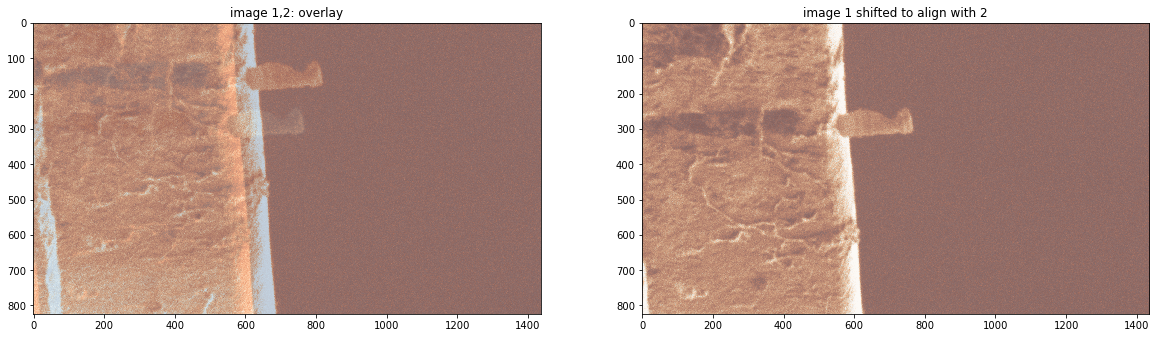

In [71]:
#     aligned = np.copy(image_1)
#     aligned = np.roll(aligned, +int(shift_01_x), axis=0)
#     aligned = np.roll(aligned, +int(shift_01_y), axis=1)
#     aligned_smooth = ndi.filters.gaussian_filter( aligned, sigma=3)

pixelsize_x = img1.metadata.binary_result.pixel_size.x

dx = 1.693e-06
dy = -4.329e-06

dx_pixels = -dx / pixelsize_x
dy_pixels = -dy   / pixelsize_x  

print(pixelsize_x)
print(dx_pixels, dy_pixels)
aligned = np.copy(img2.data)
aligned = np.roll(aligned, int(dy_pixels), axis=0)
aligned = np.roll(aligned, int(dx_pixels), axis=1)
                      
import matplotlib.pyplot as plt

plt.figure(1, figsize=(20, 20))
plt.subplot(2,2,1)
plt.title('image 1,2: overlay')
plt.imshow( img1.data[200:, :-100], cmap='Blues_r',   alpha=0.5)
plt.imshow( img2.data[200:, :-100], cmap='Oranges_r', alpha=0.5)
plt.subplot(2,2,2)
plt.title('image 1 shifted to align with 2')
plt.imshow( img1.data[200:, :-100], cmap='Blues_r',   alpha=0.5)
plt.imshow( aligned[200:, :-100], cmap='Oranges_r', alpha=0.5)




# cross products
# print(img1.data.shape)
# ret_1 = np.cross(img1.data, img2.data.T)
# # ret_2 = np.cross(img1.data, aligned.T)

# print(ret_1)
# print(ret_2)


# import cv2
# from skimage import compare_ssim

from skimage.metrics import structural_similarity
# img = cv2.imread('img_1.png')
# img_2 = cv2.imread('img_2.png')

print(structural_similarity(img1.data[200:, :-100], img2.data[200:, :-100]))
print(structural_similarity(img1.data[200:, :-100], aligned[200:, :-100]))

8 1.5 2.5 1389621.335303811 (509, 709)


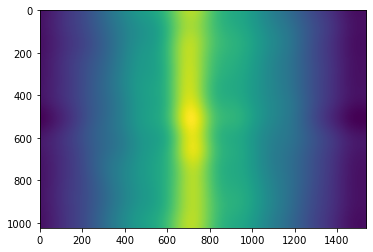

8 1.5 10 1394077.6409766038 (512, 708)


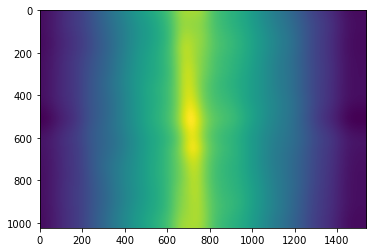

8 1.5 45 1300863.4484798089 (644, 717)


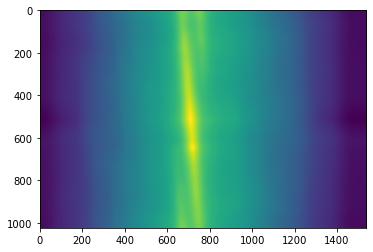

64 1.5 2.5 1268814.5996738106 (645, 716)


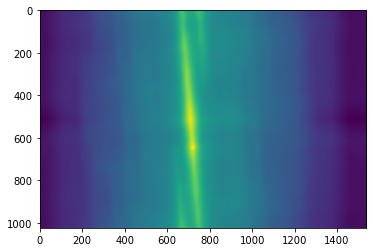

64 1.5 10 1297968.5624300845 (645, 716)


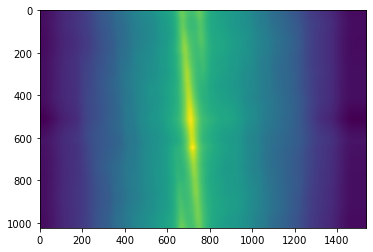

64 1.5 45 1299605.5052705004 (645, 716)


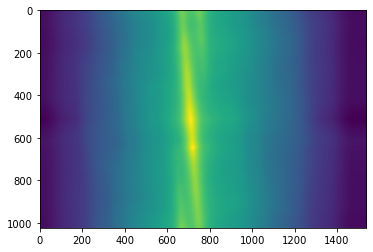

64 12 2.5 1282191.3736051472 (645, 716)


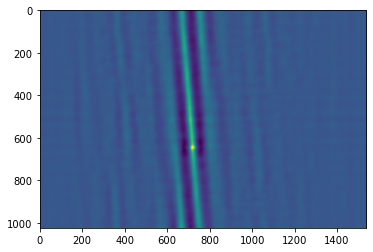

64 12 10 1281455.3759134808 (645, 716)


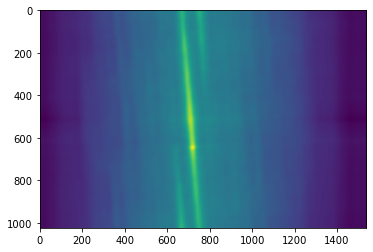

64 12 45 1299531.40167823 (645, 716)


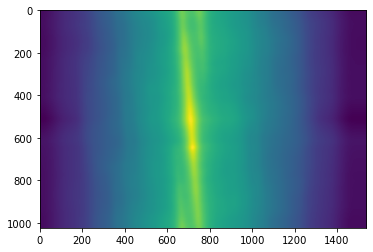

64 48 2.5 1296485.6781655322 (645, 716)


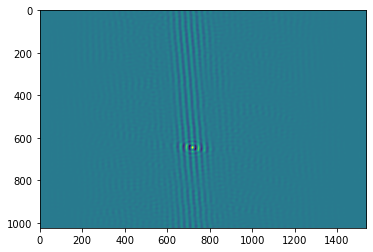

64 48 10 1284463.1367202874 (645, 716)


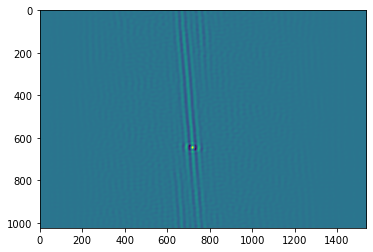

64 48 45 1298421.895264227 (645, 716)


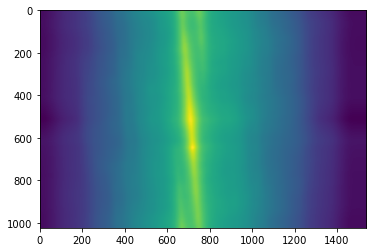

256 1.5 2.5 1249217.368710782 (645, 716)


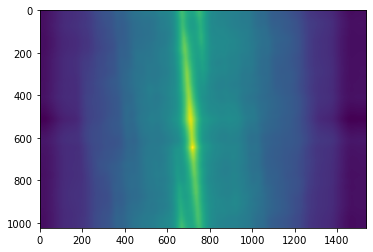

256 1.5 10 1281642.7957438151 (645, 716)


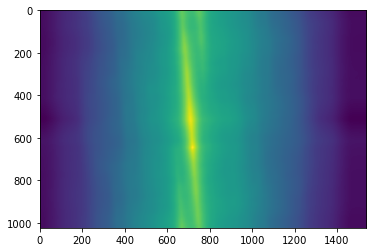

256 1.5 45 1285170.347522221 (645, 716)


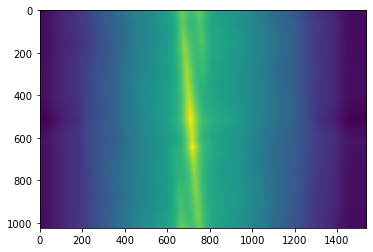

256 12 2.5 1208237.9377890422 (645, 716)


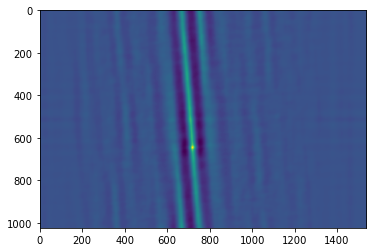

256 12 10 1240932.4457403591 (645, 716)


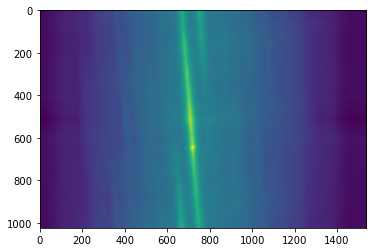

256 12 45 1284151.127120906 (645, 716)


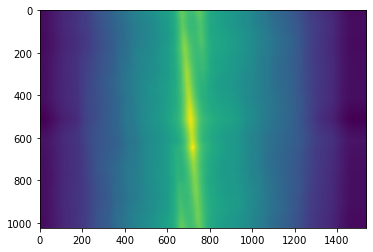

256 48 2.5 935635.9056725253 (645, 716)


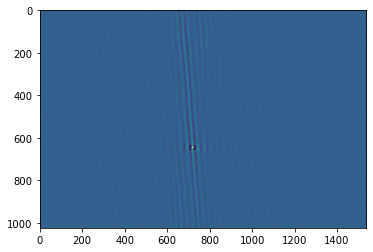

256 48 10 925571.6553627381 (645, 716)


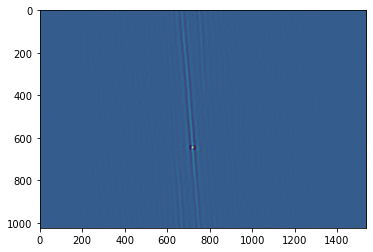

256 48 45 1260350.8217400545 (645, 716)


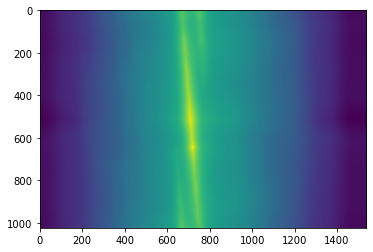

In [82]:

lp_values = [8, 64, 256]
hp_values = [1.5, 12, 48]
sigma_values = [2.5,10, 45]

for i, lp in enumerate(lp_values):
    for j, hp in enumerate(hp_values):
        for k, sigma in enumerate(sigma_values):

            
            if hp> lp: 
                continue
            highpass, lowpass, sigma = hp, lp, sigma
            use_rect_mask = True
            img1_data_norm = (img1.data - np.mean(img1.data)) / np.std(img1.data)
            img2_data_norm = (img2.data - np.mean(img2.data)) / np.std(img2.data)
            # cross-correlate normalised images
            if use_rect_mask:
                rect_mask = calibration._mask_rectangular(img2_data_norm.shape)
                img1_data_norm = rect_mask * img1_data_norm
                img2_data_norm = rect_mask * img2_data_norm
            xcorr = calibration.crosscorrelation(
                img1_data_norm, img2_data_norm, bp="yes", lp=lowpass, hp=highpass, sigma=sigma
            )
            
            print(lp, hp, sigma, np.max(xcorr), np.unravel_index(np.argmax(xcorr), xcorr.shape))
#             print(xcorr)
#             print(xcorr.shape)

            plt.imshow(xcorr)
            plt.show()